In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pickle

In [2]:
def give_cl_cmb(ell, r=0, Alens=1.):
        
    power_spectrum = hp.read_cl('/home/nahue-ofi/CMM-Pipeline/src/data/Cls_Planck2018_lensed_scalar.fits')[:,:4000]
    if Alens != 1.:
        power_spectrum[2] *= Alens
    if r:
        power_spectrum += r * hp.read_cl('/home/nahue-ofi/CMM-Pipeline/src/data/Cls_Planck2018_unlensed_scalar_and_tensor_r1.fits')[:,:4000]
    return np.interp(ell, np.arange(1, 4001, 1), power_spectrum[2])

with open('/home/nahue-ofi/CMM-Pipeline/src/autospectrum_realistic_in_cmb_d1_s0_out_cmb_d1_parametric_d1_two.pkl', 'rb') as f: #autospectrum_realistic_in_cmb_d1_s0_out_cmb_d1_parametric_d1_two #autospectrum_forecast_inCMBDustSync_outCMBDustSync_advancedparametric_d0_two
    data = pickle.load(f)

# with open('/home/nahue-ofi/CMM-Pipeline/src/autospectrum_cmbseed1_50reals_nofg.pkl', 'rb') as f:
#     datanofg = pickle.load(f)

_f = data['ell'] * (data['ell'] + 1) / (2 * np.pi)

In [145]:
print(data.keys())
print( np.shape(data['DlBB_i']))
nreals = np.shape(data['DlBB_i'])[0]

dict_keys(['ell', 'DlBB_i', 'DlBB_i_res', 'DlBB_mean', 'DlBB_mean_res'])
(100, 2, 2, 16)


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

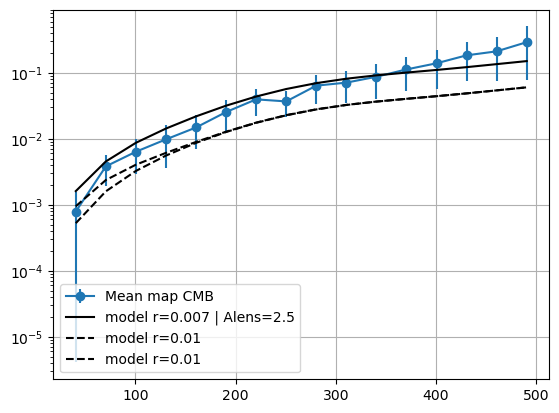

In [172]:
Alens = 2.5
r = 0.007

plt.figure()

# for i in range(nreals):
#     plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-data['DlBB_i_res'][i,0,0,:],'.')

# plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:,0,0,:]- data['DlBB_i_res'][:,0,0,:],axis=0), fmt='-o', label='averaged spectrum CMB')
plt.errorbar( data['ell'], data['DlBB_mean'][0,0,:], yerr = data['DlBB_mean_res'][0,0,:], fmt = '-o', label = 'Mean map CMB' )
# plt.errorbar( data['ell'], data['DlBB_mean_res'][0,0,:], fmt='-o', label='Bias CMB')
# plt.errorbar( data['ell'], data['DlBB_mean'][0,0,:]-data['DlBB_mean_res'][0,0,:], fmt='-o', label='Mean - bias')
plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], r, Alens), fmt='-k', label=f'model r={r} | Alens={Alens}')
plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], 0, 1), fmt='--k', label='model r=0.01')
plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], 0.01, 1), fmt='--k', label='model r=0.01')

plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout

# plt.figure()

# # for i in range(nreals):
# #     plt.plot(data['ell'], data['DlBB_i'][i,0,0,:]-data['DlBB_i_res'][i,0,0,:],'.')

# plt.errorbar( data['ell'], np.mean(data['DlBB_i'][:,0,0,:]- data['DlBB_i_res'][:,0,0,:],axis=0), fmt='-o', label='averaged spectrum CMB')
# plt.errorbar( data['ell'], data['DlBB_mean'][0,0,:], fmt='-o', label='Mean map CMB')
# plt.errorbar( data['ell'], data['DlBB_mean_res'][0,0,:], fmt='-o', label='Bias CMB')
# plt.errorbar( data['ell'], data['DlBB_mean'][0,0,:]-data['DlBB_mean_res'][0,0,:], fmt='-o', label='Mean - bias')
# plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], 0, Alens), fmt='-k', label='model r=0')
# plt.errorbar( data['ell'], _f * give_cl_cmb(data['ell'], 0.01, Alens), fmt='--k', label='model r=0.01')

# plt.yscale('log')
# plt.grid()
# plt.legend()
# plt.tight_layout

# plt.figure()

# delta_1 = 2 * (data['DlBB_mean'][0,0,:] - np.mean(data['DlBB_i'][:,0,0,:],axis=0)) / (data['DlBB_mean'][0,0,:] + np.mean(data['DlBB_i'][:,0,0,:],axis=0))
# delta_2 = 2 * (data['DlBB_mean_res'][0,0,:] - np.mean(data['DlBB_i_res'][:,0,0,:],axis=0)) / ((data['DlBB_mean_res'][0,0,:] + np.mean(data['DlBB_i_res'][:,0,0,:],axis=0)))
# delta_3 = 2 * ((data['DlBB_mean'][0,0,:] - data['DlBB_mean_res'][0,0,:]) - 
#                ( np.mean( data['DlBB_i'][:,0,0,:] - data['DlBB_i_res'][:,0,0,:],axis=0))) / ((data['DlBB_mean'][0,0,:] - data['DlBB_mean_res'][0,0,:])+( np.mean( data['DlBB_i'][:,0,0,:] - data['DlBB_i_res'][:,0,0,:],axis=0)))

# plt.errorbar( data['ell'], np.abs(delta_1), fmt='-o', label='Dl meanmap - mean Dl')
# plt.errorbar( data['ell'], np.abs(delta_2), fmt='-o', label='Dl bias - mean residuals Dl')
# plt.errorbar( data['ell'], np.abs(delta_3), fmt='-o', label='Mean - bias')

# plt.yscale('log')
# plt.legend()
# plt.tight_layout

In [121]:
# cov_cc = np.cov(data['DlBB_i'][:, 0, 0,:], rowvar=False)
cov_cc = np.cov(data['DlBB_i'][:, 0, 0,:] - data['DlBB_i_res'][:, 0, 0,:], rowvar=False)

# cov_cc = np.cov(data['Dl'][:-1, 0] - data['Dl_1x1'][:-1], data['Dl'][:-1, 0] - data['Dl_1x1'][:-1], rowvar=False)[:16, :16]
# cov_cc = np.cov(data['Dl'][:, 0] - np.mean(data['Dl_1x1'],axis=0), rowvar=False)
# cov = np.zeros((16,16))
# np.fill_diagonal(cov, np.sqrt(data['DlBB_mean_res'][0,0,:]))
# np.fill_diagonal(cov, np.std(data['Dl'][:,0]-data['Dl_1x1'], axis=0)**2)
# np.fill_diagonal(cov, np.std(data['Dl'][:,0]-data['Dl_1x1'][:], axis=0)[0]**2)


# cov_cc_nofg = np.cov(datanofg['Dl'][:, 0] - datanofg['Dl_1x1'][:], datanofg['Dl'][:, 0] - datanofg['Dl_1x1'][:], rowvar=False)[:16, :16]
# cov_cc_nofg = np.cov(datanofg['Dl'][:-1, 0] - datanofg['Dl_1x1'][:-1], datanofg['Dl'][:-1, 0] - datanofg['Dl_1x1'][:-1], rowvar=False)[:16, :16]
# cov_cc_nofg = np.cov(datanofg['Dl'][:, 0] - np.mean(datanofg['Dl_1x1'],axis=0), rowvar=False)
# cov_nofg = np.zeros((16,16))
# np.fill_diagonal(cov_nofg, np.std(datanofg['Dl'], axis=0)**2)
# np.fill_diagonal(cov_nofg, np.std(datanofg['Dl'], axis=0)[0]**2)

#cov_dd = np.cov(data['Dl'][:, 1] - data['Dl_2x2'], data['Dl'][:, 1] - data['Dl_2x2'], rowvar=False)[16:32, 16:32]
#cov_dc = np.cov(data['Dl'][:, 1] - data['Dl_2x2'], data['Dl'][:, 0] - data['Dl_1x1'], rowvar=False)[16:32, :16]
#cov_cd = np.cov(data['Dl'][:, 0] - data['Dl_1x1'], data['Dl'][:, 1] - data['Dl_2x2'], rowvar=False)[:16, 16:32]

# cov_cc = np.cov(data['Dl'][:, 0] - (np.mean(data['Dl_1x1'],axis=0) + 0*np.random.normal(loc=0,scale=np.std(data['Dl_1x1'],axis=0))), rowvar=False)
#cov_dd = np.cov(data['Dl'][:, 1] - data['Dl_2x2'], rowvar=False)
#cov_dc = np.cov(data['Dl'][:, 1] - data['Dl_2x2'], data['Dl'][:, 0] - data['Dl_1x1'], rowvar=False)[16:32, :16]
#cov_cd = np.cov(data['Dl'][:, 0] - data['Dl_1x1'], data['Dl'][:, 1] - data['Dl_2x2'], rowvar=False)[:16, 16:32]

#cov_cc = np.cov(data['Dl'][:, 0], rowvar=False)
#cov_dd = np.cov(data['Dl'][:, 1], rowvar=False)
#cov_dc = np.cov(data['Dl'][:, 1], data['Dl'][:, 0], rowvar=False)[16:32, :16]
#cov_cd = np.cov(data['Dl'][:, 0], data['Dl'][:, 1], rowvar=False)[:16, 16:32]

# cov_cc = np.cov(data['Dl'][:, 0], rowvar=False)
#cov_dd = np.cov(data['Dl'][:, 1], rowvar=False)

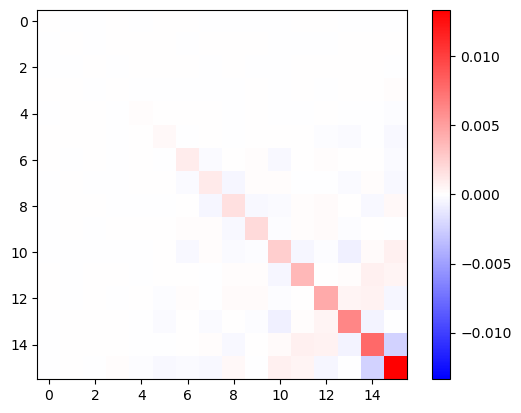

In [122]:
plt.figure()
vmax = np.max(np.abs(cov_cc[:, :]))
plt.imshow(cov_cc[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()

# plt.figure()
# vmax = np.max(np.abs(cov[:, :]))
# plt.imshow(cov[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
# # plt.title('Covariance pixel 0')
# plt.colorbar()

# plt.figure()
# vmax = np.max(np.abs(cov_cc_nofg[:, :]))
# plt.imshow(cov_cc_nofg[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
# # plt.title('Covariance pixel 0')
# plt.colorbar()

# plt.figure()
# vmax = np.max(np.abs(cov_nofg[:, :]))
# plt.imshow(cov_nofg[:, :], vmin=-vmax, vmax=vmax, cmap='bwr')
# # plt.title('Covariance pixel 0')
# plt.colorbar()

In [162]:
def foregrounds(ell, A, alpha):
    return A * (ell/80)**alpha
    
def log_prior(x):
    r, Alens = x
    if r > 1 or r < -1:
        return -np.inf

    if Alens < 0.1 or Alens > 3:
        return -np.inf

    # if alpha > 0 or alpha < -1:
    #    return -np.inf
    return 0

def like(x):

    r, Alens = x

    ymodel = np.array([_f * give_cl_cmb(data['ell'], r, Alens)])#, foregrounds(data['ell'], A, alpha)])

    yobs = np.array(data['DlBB_mean'][0,0,:])#-data['DlBB_mean_res'][0,0,:])
                    #, np.mean(data['Dl'], axis=0)[1] - np.mean(data['Dl_2x2'], axis=0)])

    res = ymodel - yobs

    lp = log_prior(x)

    L_cmb_cmb = lp - 0.5 * ((res[0].T @ np.linalg.inv(cov_cc) @ res[0]))
    
    #L_dust_cmb = lp - 0.5 * (res[1].T @ np.linalg.inv(cov_dc) @ res[1])
    #L_cmb_dust = lp - 0.5 * (res[0].T @ np.linalg.inv(cov_cd) @ res[0])
    #L_dust_dust = lp - 0.5 * (res[1].T @ np.linalg.inv(cov_dd) @ res[1])

    L = L_cmb_cmb # + L_dust_dust + L_dust_cmb + L_cmb_dust
    
    return L

In [163]:
import emcee
from multiprocess import Pool
from getdist import plots, MCSamples

nwalkers = 30

In [164]:
x0 = np.zeros((nwalkers, 2))

x0[:, 0] = np.random.normal(0.036, 0.01, (nwalkers))
x0[:, 1] = np.random.normal(1, 0.01, (nwalkers))
#x0[:, 2] = np.random.normal(-0.1, 0.001, (nwalkers))
#x0[:, 3] = np.random.normal(-0.1, 0.001, (nwalkers))
#x0[:, 2] = np.random.normal(-0.5, 0.001, (nwalkers))

In [165]:
from multiprocess import Pool

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, x0.shape[1], like, pool=pool)
    sampler.run_mcmc(x0, 3000)#, progress=True)

In [166]:
chainflat = sampler.get_chain(discard=300, thin=15, flat=True)
chains = sampler.get_chain()

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

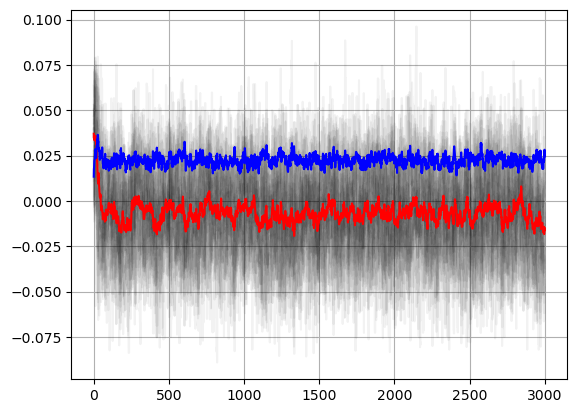

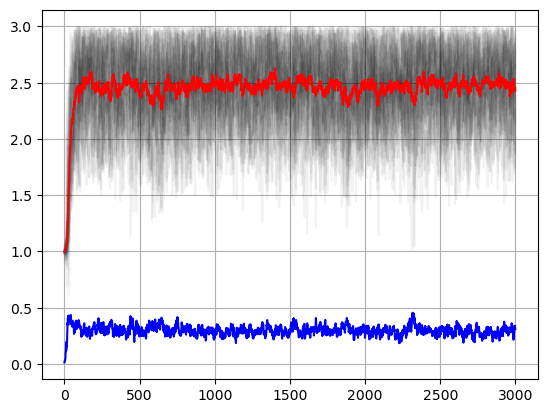

In [167]:
plt.figure()

for i in range(nwalkers):
    plt.plot(chains[:, i, 0], '-k', alpha=0.05)
plt.plot(np.mean(chains, axis=1)[:, 0], '-r')
plt.plot(np.std(chains, axis=1)[:, 0], '-b')
# plt.axhline(0, ls='--', color='black')
# plt.axhline(0.015, ls='--', color='green')
# plt.xlim(0, chains.shape[0])
# plt.ylim(-0.05, 0.1)
plt.grid()
plt.tight_layout


plt.figure()

for i in range(nwalkers):
    plt.plot(chains[:, i, 1], '-k', alpha=0.05)
plt.plot(np.mean(chains, axis=1)[:, 1], '-r')
plt.plot(np.std(chains, axis=1)[:, 1], '-b')
# plt.axhline(0, ls='--', color='black')
# plt.axhline(0.015, ls='--', color='green')
# plt.xlim(0, chains.shape[0])
# plt.ylim(-0.05, 0.1)
plt.grid()
plt.tight_layout

Removed no burn in


<Figure size 1200x800 with 0 Axes>

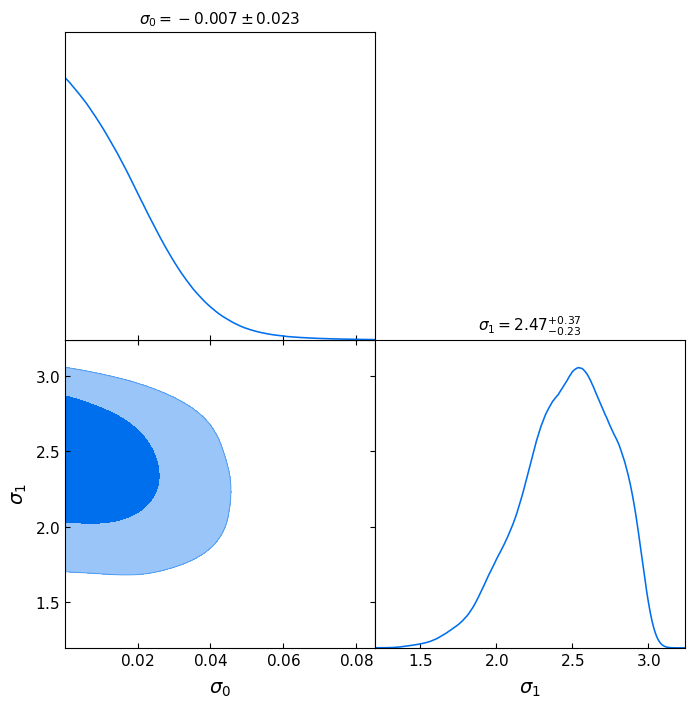

In [168]:
labels = []
names = []

for i in range(chains.shape[2]):
    names += [f'sig_{i}']
    labels += [f'\sigma_{i}']
            
s = MCSamples(samples=chainflat, names=names, labels=labels, label=r'', ranges={'sig_0':(0, None)})

plt.figure(figsize=(12, 8))

# Triangle plot
g = plots.get_subplot_plotter(width_inch=8)
g.triangle_plot([s], filled=True, title_limit=1)
plt.savefig('d0 - diagonal cov corrected')
plt.show()